## Setup

### Setup Environment

In [1]:
import os
import torch
import torchinfo
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

In [2]:
# Check version
print("Using torch", torch.__version__)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
torch.manual_seed(42)
np.random.seed(42)

# Setup GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    # ensure that all operations are deterministic on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using torch 2.1.2+cu118


### Download Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, downloading data...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## Data Exploration

Image Shape: 512 x 512


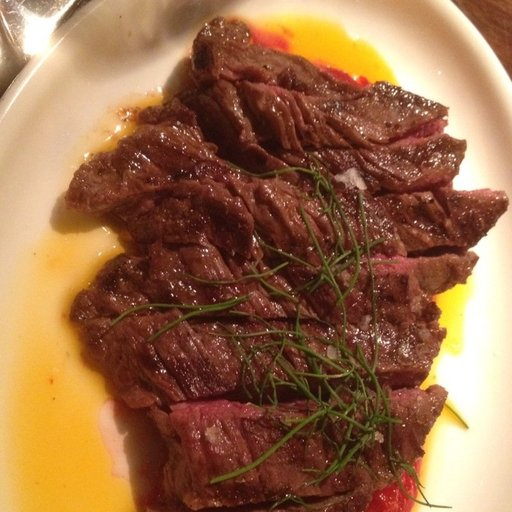

In [4]:
from PIL import Image

img = np.random.choice(os.listdir(os.path.join(image_path, "train", "steak")), 1)
img = os.path.join(image_path, "train", "steak", img[0])
img = Image.open(img)
print(f"Image Shape: {img.height} x {img.width}")
img

### Using Transformations

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

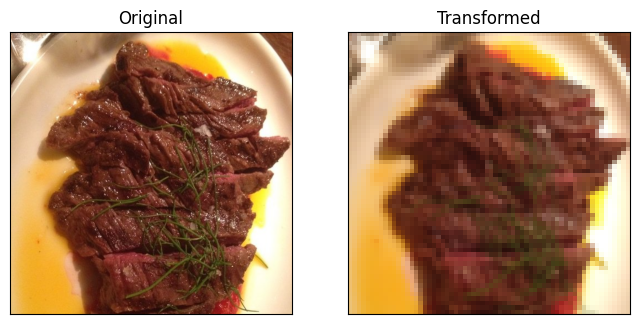

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.imshow(np.array(img))
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(data_transform(img).permute(1, 2, 0))
ax2.set_title("Transformed")
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

## Data Loading

### Method 1: ImageFolder

In [7]:
train_data = datasets.ImageFolder(root="./data/pizza_steak_sushi/train",
                                  transform=data_transform)
test_data = datasets.ImageFolder(root="./data/pizza_steak_sushi/test",
                                 transform=data_transform)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: ./data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: ./data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [8]:
print(train_data.classes)
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [9]:
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=16,
                               shuffle=True,
                               num_workers=4)

train_data_loader

In [10]:
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=16,
                              shuffle=True,
                              num_workers=4)

test_data_loader

In [11]:
image, label = next(iter(train_data_loader))

image.shape, label

(torch.Size([16, 3, 64, 64]),
 tensor([1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1]))

In [12]:
image, label = next(iter(test_data_loader))

image.shape, label

(torch.Size([16, 3, 64, 64]),
 tensor([1, 0, 2, 1, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 0]))

### Method 2: Custom Dataset

In [13]:
from typing import Tuple, List, Dict

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory

    Parameters
    ----------
    directory : str
        target directory to load classnames from.

    Returns
    -------
    Tuple[List[str], Dict[str, int]]
        list of class names and dictionary of class names and index
    """
    classes = [item.name for item in os.scandir(directory) if item.is_dir()]

    if not classes:
        raise FileNotFoundError(f"There is no folder in {directory}")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [14]:
import pathlib

class ImageFolderCustom(Dataset):
    def __init__(self, path, data_transform = None) -> None:
        super().__init__()
        self.data_transform = data_transform
        self.path = path
        self.find_classes()
        self.find_images()

    def find_classes(self) -> None:
        self.classes, self.class_to_idx = find_classes(self.path)
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

    def find_images(self) -> None:
        self.image_paths = list(pathlib.Path(self.path).glob("*/*.jpg"))
        self.image_paths += list(pathlib.Path(self.path).glob("*/*.jpeg"))
        self.image_paths += list(pathlib.Path(self.path).glob("*/*.png"))

    def load_image(self, index: int) -> Image.Image:
        return Image.open(self.image_paths[index])
    
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.image_paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.data_transform: 
            return self.data_transform(img), class_idx

        return img, class_idx

In [15]:
train_data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom("./data/pizza_steak_sushi/train", train_data_transform)
test_data_custom = ImageFolderCustom("./data/pizza_steak_sushi/test", test_data_transform)

len(train_data_custom), len(test_data_custom)

(225, 75)

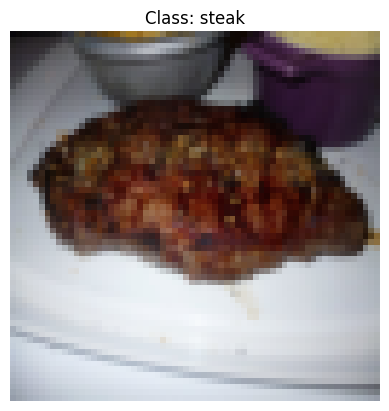

In [16]:
idx = np.random.randint(0, len(train_data_custom))
data_img, data_lbl = train_data_custom[idx]
plt.imshow(data_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Class: {train_data_custom.idx_to_class[data_lbl]}")
plt.show()

In [17]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [18]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=16, 
                                     num_workers=0, 
                                     shuffle=True) 
                                     
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=16, 
                                    num_workers=0, 
                                    shuffle=False)

In [19]:
data_imgs, data_lbls = next(iter(train_dataloader_custom))

data_imgs.shape, data_lbls.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

## Data Augmentation

In [20]:
train_augment_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=15),
    transforms.ToTensor()
])

In [21]:
train_data_augment = ImageFolderCustom("./data/pizza_steak_sushi/train", train_augment_transform)

In [22]:
train_dataloader_augment = DataLoader(dataset=train_data_augment,
                                      batch_size=16, 
                                      num_workers=0, 
                                      shuffle=True) 

## Modelling

In [23]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*8*8, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.classifier(x)
        return x

In [24]:
from tqdm.notebook import tqdm

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 30) -> Dict[str, list]:
    history = {"loss": [], "acc": []}
    model.train()

    for _ in tqdm(range(epochs)):
        current_loss, current_acc = 0, 0

        for X, y in dataloader:
            # Step 1: move data into the appropriate device
            X = X.to(device)
            y = y.to(device)

            # Step 2: Run the model on input data
            preds = model(X)
            preds = preds.squeeze(dim=1)

            # Step 3: Calculate the loss
            loss = loss_fn(preds, y)

            # Step 4: Perform backpropagation
            optimizer.zero_grad() # ensure gradients are zero            
            loss.backward() # perform backpropagation

            # Step 5: Update the parameters
            optimizer.step()

            pred_labels = preds.argmax(dim=1)
            current_loss += loss.item()
            current_acc += (pred_labels == y).sum().item() / len(pred_labels)

        history["loss"].append(current_loss / len(dataloader))
        history["acc"].append(current_acc / len(dataloader))
    
    return history

In [25]:
def test(model, data_loader):
    model.eval()
    true_preds = 0.0
    num_preds = 0.0
    
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = preds.argmax(dim=1)

            true_preds += (pred_labels == y).sum()
            num_preds += y.shape[0]
        acc = true_preds / num_preds
    return acc

In [26]:
def plot_history(history):
    accuracy = history["acc"]
    loss = history["loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(epochs, accuracy, 'b-', label='Accuracy')
    ax1.set_title('Accuracy over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(epochs, loss, 'r-', label='Loss')
    ax2.set_title('Loss over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

    plt.show()

### Baseline Model (Trained without Augmentation)

In [27]:
model_baseline = TinyVGG(3, 10, len(train_data_custom.classes))
model_baseline = model_baseline.to(device)
torchinfo.summary(model_baseline)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-11                      910
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      910
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
├─Sequential: 1-4                        --
│    └─Flatten: 2-16                     --
│    └─Linear: 2-17  

In [28]:
optimizer = torch.optim.SGD(model_baseline.parameters(), lr=0.05)
history_baseline = train(model_baseline,
                         train_dataloader_custom,
                         optimizer,
                         epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

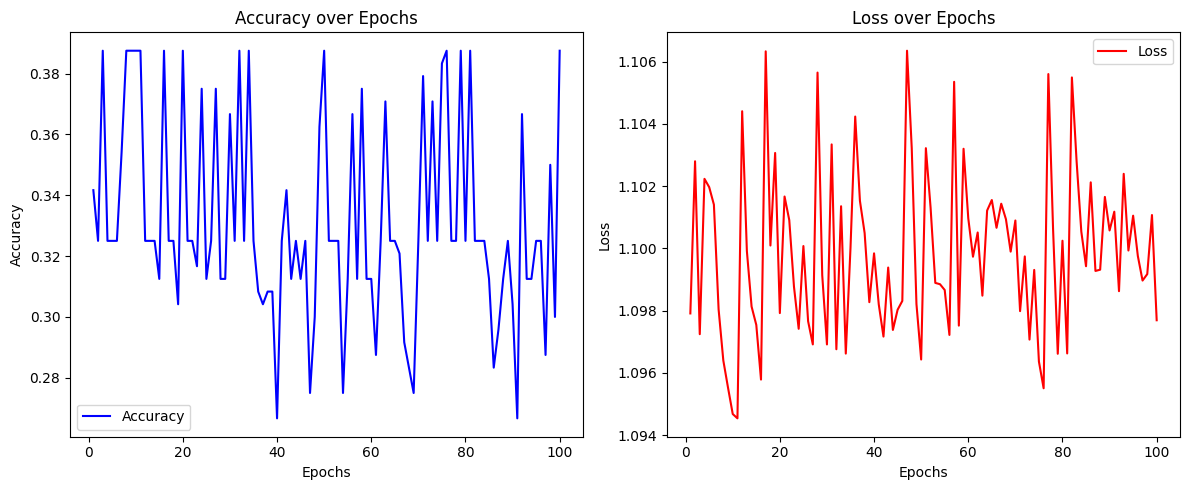

In [29]:
plot_history(history_baseline)

In [30]:
test(model_baseline, train_dataloader_custom)

tensor(0.3467, device='cuda:0')

### Primary Model (Trained with Augmentation)

In [31]:
model = TinyVGG(3, 10, len(train_data_custom.classes))
model = model.to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-11                      910
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      910
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
├─Sequential: 1-4                        --
│    └─Flatten: 2-16                     --
│    └─Linear: 2-17  

In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
history_baseline = train(model,
                         train_dataloader_augment,
                         optimizer,
                         epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

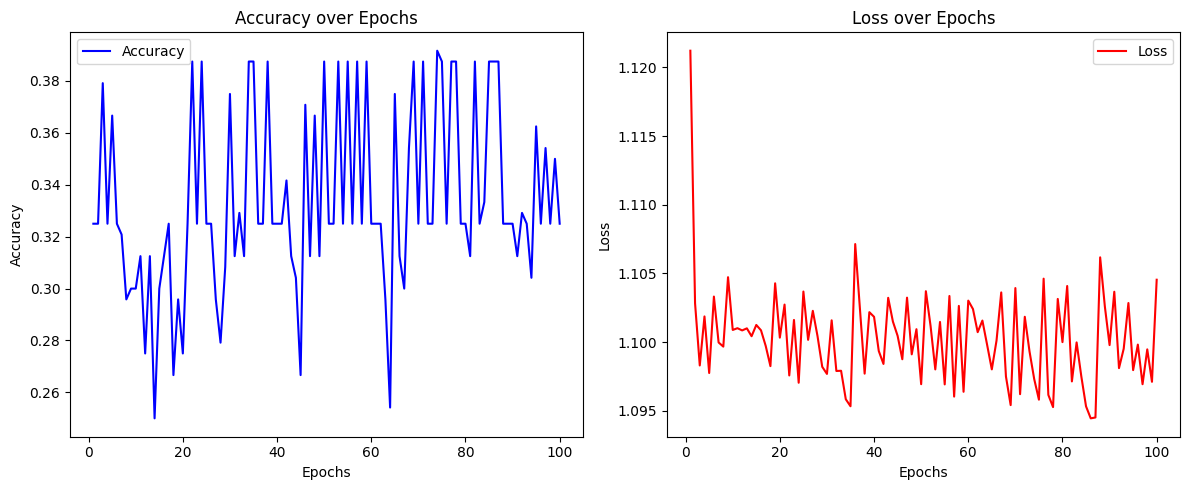

In [33]:
plot_history(history_baseline)

In [34]:
test(model, train_dataloader_custom)

tensor(0.3467, device='cuda:0')

### Prediction on Test Images

In [35]:
test(model_baseline, test_dataloader_custom)

tensor(0.3333, device='cuda:0')

In [36]:
test(model, test_dataloader_custom)

tensor(0.3333, device='cuda:0')

## Prediction on New Image

In [37]:
def pred_image(model: torch.nn.Module,
               image_path: str,
               transform = None,
               device = "cpu"):
    img = Image.open(image_path)
    if not transform:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])
    img = transform(img)
    img = img.to(device)

    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        pred = model(img.view(1, 3, 64, 64))
        pred_probs = torch.softmax(pred, dim=1)

    return pred_probs.argmax(dim=1).item(), torch.max(pred_probs).item()


In [38]:
print(pred_image(model, "./data/sample_pizza.jpg"))
print(pred_image(model, "./data/sample_sushi.jpg"))
print(pred_image(model, "./data/sample_steak.jpg"))

(0, 0.35129350423812866)
(0, 0.3511638641357422)
(0, 0.35111817717552185)
